<a href="https://colab.research.google.com/github/dinhngoc267/clustering_algorithm/blob/main/A_worked_out_example_for_EM_(Expectation_Maximization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

When it comes to k-means, the notion of clusters is straightforward --each point belongs to the cluster with the nearest centroid (mean). If someone gave us some data points and centroids, we can readily label each point for cluster.

The notion of clusters for EM is not as immediately intuitive. Before jumping into the minutiae of EM, it is best to develop your intuition as to what clusters really mean. 

### Prelude: cluster assignment in k-means

Let us consider a toy example with three data points in 2D

In [ ]:
abcsdaf

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
data = [[10,5], [2,1], [3,7]]

data_points = pd.DataFrame(data = data, columns = ['X', 'Y'])
data_points

,X,Y
0,10,5
1,2,1
2,3,7


(0.0, 12.0)

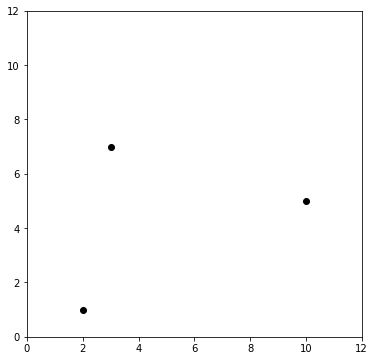

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(data_points['X'], data_points['Y'], color ='black')
plt.ylim(0, 12)
plt.xlim(0,12)

If we were running k-means, we would first take an initial set of centroids and then label all points with the closest ones. Let's take the following centroids:

In [ ]:
centroids = [[3,4], [6,3], [4,6]]

centroids_df = pd.DataFrame(data=centroids, columns = ['X','Y'])
centroids_df.index = ['Centroid A','Centroid B','Centroid C']
centroids_df

,X,Y
Centroid A,3,4
Centroid B,6,3
Centroid C,4,6


(0.0, 12.0)

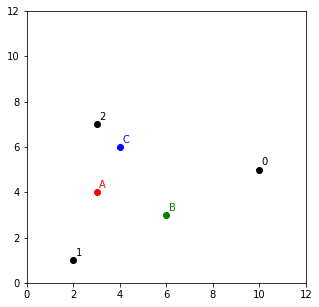

In [ ]:
colors = ['red', 'green', 'blue']
plt.figure(figsize=(5,5))

plt.scatter(data_points['X'], data_points['Y'], color ='black')

for i in range(len(centroids_df)):
  plt.scatter(centroids_df['X'][i], centroids_df['Y'][i], color = colors[i])

for i in range(len(data_points)):
  plt.annotate(str(i),(data_points['X'].values[i]+0.1, data_points['Y'].values[i]+0.2))
  plt.annotate(chr(65+i), (centroids_df['X'].values[i]+0.1, centroids_df['Y'].values[i]+0.2), color = colors[i])

plt.ylim(0, 12)
plt.xlim(0,12)

(Since this is a toy example, let's ignore the fact that having three clusters over three data points is an overkill. But I digress). Using the pairwise Euclidean distances, we label the data points with nearest clusters:


In [ ]:
import math

In [ ]:
pairwise_distances = []

for point in data:
  tmp = []
  for centroid in centroids:
    dis = math.sqrt((point[0]-centroid[0])**2 + (point[1]-centroid[1])**2)
    tmp.append(dis)
  pairwise_distances.append(tmp)  

pairwise_distances_df = pd.DataFrame(data = pairwise_distances, columns = ['Centroid of Cluster A', 'Centroid of Cluster B', 'Centroid of Cluster C' ])
pairwise_distances_df.index = ['Data point 0', 'Data point 1', 'Data point 2']
pairwise_distances_df


,Centroid of Cluster A,Centroid of Cluster B,Centroid of Cluster C
Data point 0,7.071068,4.472136,6.082763
Data point 1,3.162278,4.472136,5.385165
Data point 2,3.000000,5.000000,1.414214


In [ ]:
if 'Cluster Assignment' in pairwise_distances_df.columns:
  pairwise_distances_df.drop(columns = 'Cluster Assignment', inplace=True, axis=1)

def assign_cluster(row):
  min = 0
  for i in range(1,len(row)):
    if row[i] < row[min]:
      min = i

  return chr(65+min)

pairwise_distances_df['Cluster Assignment'] =  pairwise_distances_df.apply(lambda x: assign_cluster(x), axis=1)
pairwise_distances_df

,Centroid of Cluster A,Centroid of Cluster B,Centroid of Cluster C,Cluster Assignment
Data point 0,7.071068,4.472136,6.082763,B
Data point 1,3.162278,4.472136,5.385165,A
Data point 2,3.000000,5.000000,1.414214,C


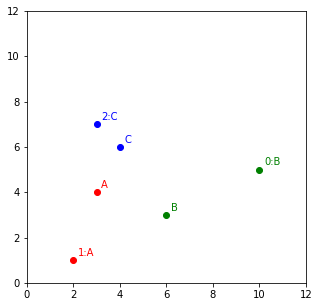

In [ ]:
plt.figure(figsize=(5,5))
plt.ylim(0,12)
plt.xlim(0,12)
for i in range(len(data_points)):
  color = colors[ord(pairwise_distances_df['Cluster Assignment'][i]) - 65]
  cluster = pairwise_distances_df['Cluster Assignment'][i]
  plt.scatter(data_points['X'][i], data_points['Y'][i], color = color)
  plt.annotate(str(i) + ':' + cluster, (data_points['X'][i] + 0.2, data_points['Y'][i] + 0.2), color= color)

  plt.scatter(centroids_df['X'][i], centroids_df['Y'][i], color = colors[i])
  plt.annotate(chr(65+i), (centroids_df['X'][i] + 0.2, centroids_df['Y'][i] + 0.2), color= colors[i])


So far so good. But what does it mean for a data point to be assigned to a cluster? For instance, data point 1 is "assigned" to cluster A and none other. That is, the entire fraction (100%) of data 1 is given to cluster A and zero fraction to cluster B and cluster C. 

### Cluster assignment in EM

So far, we've been insisting that each data point be exclusively assigned to a single cluster and no other. This often proves to be limiting, particularly when it is useful to express uncertainties regarding its cluster membership.

Looking at the pairwise distances, data point 0 was definitely closer to cluster B than any others, but for data point 1, clusters A and B were close calls. We'd like to say something like "data point 1 is most likely to belong to cluster A, but we dont want to completely rule out the possibility that it actually belongs to cluster B"

In [ ]:
pairwise_distances_df

,Centroid of Cluster A,Centroid of Cluster B,Centroid of Cluster C,Cluster Assignment
Data point 0,7.071068,4.472136,6.082763,B
Data point 1,3.162278,4.472136,5.385165,A
Data point 2,3.000000,5.000000,1.414214,C


How do we express the uncertainty? This is where the notion of **cluster responsibilities** come in. The cluster responsibilites is the fraction of a data point being represented in a certain cluster. 

#### E-step: Compute cluster responsibilities, given cluster parameters

How do we come up with the cluster responsiblities? **We look at how likely the data point is given the distribution of the cluster**. Each cluster consist of a **cluster weight**, a **mean vector** (centroid) and a **covariance matrix**. The mean defines the center of the cluster, and the covariance defines the spread. The cluster weight represents the relative representation of the cluster in the data. Summing all cluster weights yeilds 1. Finally each cluster is modeled by a multivariate Gaussian distribution. 

Let's re-visit the toy example above. We will keep same set of means and add an "ellipse of uncertainty" around each mean, as follow: 

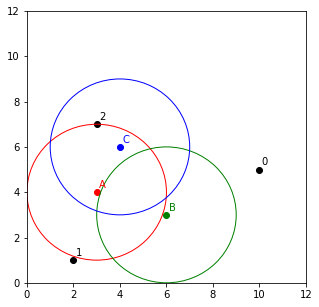

In [ ]:
colors = ['red', 'green', 'blue']
plt.figure(figsize=(5,5))

plt.scatter(data_points['X'], data_points['Y'], color ='black')

for i in range(len(centroids_df)):
  plt.scatter(centroids_df['X'][i], centroids_df['Y'][i], color = colors[i])
  plt.gca().add_patch(plt.Circle((centroids_df['X'][i], centroids_df['Y'][i]), 3, color=colors[i], fill = False))

for i in range(len(data_points)):
  plt.annotate(str(i),(data_points['X'].values[i]+0.1, data_points['Y'].values[i]+0.2))
  plt.annotate(chr(65+i), (centroids_df['X'].values[i]+0.1, centroids_df['Y'].values[i]+0.2), color = colors[i])

plt.ylim(0, 12)
plt.xlim(0,12)

plt.show()


Each ellipse visualizes the covariance matrix. In this case, all three clusters have the diagonal covariance [[3,0],[0,3]]. Since the off-diagonal entries are zero, the ellipses shown above are in fact circle. Also, since there is no reason to believe that one cluster would be better represented than other, let's assign a cluster weight of 1/3 to all clusters.

**Note**. The way we initialize covariances and weights may appear arbitrary. This is actually okay, just as initializing k-means with a random set of centroids is okay. We’ve just used an initial “estimate” of weights, means, and covariances. After computing the cluster responsibilities, we can update these parameters to arrive at a better estimate.

Let's take data point 0 and ask ourselves: How likely is the data point in the distribution of cluster A? The measure we'll be using is the **probability density function (PDF)** of the underlying Gaussian distribution.

In [ ]:
import scipy
from scipy.stats import multivariate_normal

In [ ]:
likelihoods = []

for i, point in enumerate(data):
  tmp = []
  for centroid in centroids:
    tmp.append(1/3.*multivariate_normal.pdf(point, mean=centroid, cov=[[3,0],[0,3]]))
  likelihoods.append(tmp)

normalized_likelihoods = []
for row in likelihoods:
  normalized_likelihoods.append(row/sum(row))

normalized_likelihoods_df = pd.DataFrame(data = normalized_likelihoods, columns = ['Cluster A', 'Cluster B', 'Cluster C'])
normalized_likelihoods_df


,Cluster A,Cluster B,Cluster C
0,0.006323,0.938479,0.055198
1,0.812335,0.153430,0.034235
2,0.233604,0.016232,0.750165


In [ ]:
responsibility_matrix = pd.concat((normalized_likelihoods_df, pd.DataFrame(normalized_likelihoods_df.sum(axis=0).values.reshape(1,3), columns=normalized_likelihoods_df.columns)), axis=0)
responsibility_matrix.index = ['Data point 0','Data point 1', 'Data point 2','Soft counts' ]
responsibility_matrix

,Cluster A,Cluster B,Cluster C
Data point 0,0.006323,0.938479,0.055198
Data point 1,0.812335,0.153430,0.034235
Data point 2,0.233604,0.016232,0.750165
Soft counts,1.052262,1.108140,0.839598


#### M-step: Compute cluster parameters, given cluster responsibilities

Now that we've computed the cluster responsibilities, we must revise the parameters: cluster weights, means, and covariances. Even though the initial set of parameters was a wild guess, the updated parameters will be a better guess, as they will incorporate how the data points interact with the cluster. (Again, notice a parallel to k-means, where we start with guessing the centroids and fix them later using cluster assignments)

**1. Cluster weights**. The relative importance of a cluster is determined by its soft count. Since the cluster weights must add up to 1, we add all soft counts and normalize them by their sum:

In [ ]:
soft_counts = responsibility_matrix.loc['Soft counts']
fraction_clusters = soft_counts/soft_counts.sum()
fraction_clusters

Cluster A    0.350754
Cluster B    0.369380
Cluster C    0.279866
Name: Soft counts, dtype: float64

The soft counts, normalized by their sum, are the new estimates of cluster weights. According to the soft counts, cluster A and B are larger than the average cluster size, namely 1

**2. Means**. We first add fractional parts of all data points, using the cluster responsibilites: 

muy = xichma

In [ ]:
import numpy as np

In [ ]:
new_means = []

for i, cluster in enumerate(responsibility_matrix.columns):
  weighted_sum = np.array([0,0], dtype='float')
  for k, point in enumerate(data):
    weighted_sum += np.array(point)*np.array(responsibility_matrix.iloc[k][cluster])
  new_means.append(1/responsibility_matrix.loc['Soft counts'][i] *  weighted_sum)

In [ ]:
new_means_df = pd.DataFrame(data = new_means, columns = ['X', 'Y'])
new_means_df

,X,Y
0,2.270076,2.356046
1,8.789808,4.475466
2,3.419428,6.623861


**3. Covariances**. The covariance is computed using fractional parts as well, except now we are summing matrices known as "outer products"

In [ ]:
for k,res in enumerate(responsibility_matrix.values.T):
  print(k)
  print(res)

0
[0.00632342 0.81233485 0.23360371 1.05226198]
1
[0.93847858 0.15343023 0.01623159 1.10814041]
2
[0.055198   0.03423491 0.7501647  0.83959761]


In [ ]:
new_means

[array([2.27007633, 2.35604626]),
 array([8.78980767, 4.47546561]),
 array([3.4194284 , 6.62386092])]

In [ ]:
covs = []
for k,res in enumerate(responsibility_matrix.values.T):
  cov = np.zeros(shape=(2,2), dtype='float')
  for i,point in enumerate(data):
    cov += res[i]* np.dot((np.array(point)- new_means[k]).reshape((2,1)), (np.array(point)- new_means[k]).reshape((2,1)).T)
  covs.append(cov/responsibility_matrix.loc['Soft counts'][k])

covs

[array([[0.53365916, 1.15807228],
        [1.15807228, 6.24934122]]), array([[8.11443999, 3.59078283],
        [3.59078283, 1.99877238]]), array([[ 3.08628164, -0.51799185],
        [-0.51799185,  1.58940671]])]

In [ ]:
#@title
